In [1]:
import os
import glob
import collections
import functools

import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from CCfun  import compute_baseline
from CCfun  import power_to_quanta_rate
from CCfun  import map_keys
from CCfun  import map_keys_values

from CCplot import plot1d
from CCplot import plot2d
from CCplot import plot_line
from CCplot import temporary
from CCplot import auto_plot_style

from CCdatabase import seattle_irradiation_mapping

In [2]:
%matplotlib inline

auto_plot_style()

In [3]:
Measurement = collections.namedtuple("Measurement", "crystals references background metadata")
Experiment  = collections.namedtuple("Experiment" , "pre post")

In [4]:
def load_references_from_h5(filename):
    with tb.open_file(filename) as file:
        dfs = map(pd.DataFrame.from_records,
                  map(tb.Table.read, file.root.Data.References))
        
        return pd.concat(list(dfs), ignore_index=True)

def crystal_type(crystal_id):
    ctype = crystal_id.split("_")[0].lower()
    return dict(qz = "Qz", sp = "Sp", baf = "BaF", caf = "CaF", lif = "LiF").get(ctype)

def load_metadata_from_h5(filename):
    with tb.open_file(filename) as file:
        meta  = file.root.Data.Scans.Crystals.attrs.metadata
        meta["crystal_mapping"     ] = map_keys       (meta["crystal_mapping"], int)
        meta["crystal_type_mapping"] = map_keys_values(meta["crystal_mapping"], int, crystal_type)
        return meta

def load_crystals_from_h5(filename):
    with tb.open_file(filename) as file:
        table = file.root.Data.Scans.Crystals
        df    = pd.DataFrame.from_records(table.read())
        return df

def load_backgrounds_from_h5(filename, which="Before"):
    with tb.open_file(filename) as file:
        table = getattr(file.root.Data.Backgrounds, which)
        return pd.DataFrame.from_records(table.read())

def add_crystal_meta(df, meta):
    df["crystal_id"  ] = df.crystal   .map(meta["crystal_mapping"])
    df["crystal_type"] = df.crystal   .map(meta["crystal_type_mapping"])
    df["position"    ] = df.crystal_id.map(seattle_irradiation_mapping)
    return df

def add_missing_backgrounds(df, which="Before"):
    bkg0 = df.loc[df.crystal == 1].copy()
    bkg0.crystal = 0
    
    other_crystal = 2
    if   which == "Before": other_crystal = df.crystal[df.crystal > 3].min()
    elif which != "After" : raise ValueError(f"Invalid value of argument which: {which}")

    bkg3 = df.loc[df.crystal == other_crystal].copy()
    bkg3.crystal = 3
    
    references = df[df.crystal <= 3]
    crystals   = df[df.crystal >  3]
    return pd.concat([bkg0, references, bkg3, crystals], ignore_index=True)

def add_100s_exposure(df):
    extras      = []
    ten_seconds = df[df.exposure == 10]
    for crystal in set(ten_seconds.crystal.values):
        extra          = ten_seconds.loc[ten_seconds.crystal == crystal].copy()
        baseline       = compute_baseline(extra.counts)
        spectrum       = (extra.counts - baseline) * 10 + baseline
        extra.counts   = spectrum.astype(df.dtypes["counts"])
        extra.exposure = 100
        extras.append(extra)
    return pd.concat([df, *extras], ignore_index=True)

def df_mask(df, selection_dict):
    selection = True
    for column, value in selection_dict.items():
        selection &= df[column] == value
    return selection

def select_df(df, sel_dict):
    selection = df_mask(df , sel_dict)
    if np.count_nonzero(selection) == 0:
        raise RuntimeError("Empty DataFrame")
    return df[selection]

def get_crystal_id(meta_pre, crystal, meta_post=None):
    crystal_id_pre  = meta_pre ["crystal_mapping"][crystal]
    crystal_id_post = meta_post["crystal_mapping"][crystal] if meta_post is not None else crystal_id_pre
    assert crystal_id_pre == crystal_id_post

    return crystal_id_pre

def get_crystal_id_from_experiment(experiment, crystal):
    return get_crystal_id(experiment.pre.metadata, crystal, meta_post=experiment.post.metadata)

def process(data, background, wheel_number):
    data["bkgsub" ]  = np.nan
    for (crystal_no, exposure), bkg in background.groupby("crystal exposure".split()):
        selection    = df_mask(data, dict(crystal=crystal_no, exposure=exposure))
        bkg_counts   = np.tile(bkg.counts.astype(np.int64),
                               np.count_nonzero(selection) // len(bkg))
        data.loc[selection, "bkgsub"] = data.loc[selection, "counts"].astype(np.int64) - bkg_counts

    data["rate"   ]  = data.bkgsub / data.exposure
    data["quantar"]  = power_to_quanta_rate(data.power * 100, data.ex_wl)
    data["dquanta"]  = data.rate   / data.quantar
    
    data      ["wheel_no"] = wheel_number
    background["wheel_no"] = wheel_number

In [5]:
def load_and_process(filename, wheel_number=0):
    meta = load_metadata_from_h5   (filename)
    df   = load_crystals_from_h5   (filename)
    ref  = load_references_from_h5 (filename)
    bkg  = load_backgrounds_from_h5(filename)
    bkg  = add_missing_backgrounds (bkg     )
    bkg  = add_100s_exposure       (bkg     )
    df   = add_crystal_meta        (df, meta)
    process( df, bkg, wheel_number)
    process(ref, bkg, wheel_number)
    return Measurement(df, ref, bkg, meta)

def load_prepost(filename_pre, filename_post):
    pre  = Measurement(*load_and_process(filename_pre ))
    post = Measurement(*load_and_process(filename_post))
    return Experiment(pre, post)

def merge_measurements(measurements, sort_by=None):
    df, ref, bkg, meta = zip(*measurements)
    df    = pd.concat(df , ignore_index=True)
    ref   = pd.concat(ref, ignore_index=True)
    bkg   = pd.concat(bkg, ignore_index=True)
    
    if sort_by:
        df = df.sort_values(sort_by)
    return Measurement(df, ref, bkg, meta)

In [6]:
def plot_references(experiment):
    plt.figure(figsize=(12, 5))

    crystals  =  0, 3
    exposures = 10, 1

    for k in range(2):
        sel_data   = dict(crystal    = crystals [k],
                          exposure   = exposures[k],
                          slit_width =         1000)
        crystal_id = get_crystal_id_from_experiment(experiment, crystals[k])

        sg_pre  = select_df(experiment.pre .references, sel_data)
        sg_post = select_df(experiment.post.references, sel_data)
        assert len(sg_pre) == len(sg_post) == 1600

        plt.subplot(1, 2, k + 1)
        plot1d(sg_pre .em_wl  .values,
               sg_pre .dquanta.values,
               title  = crystal_id   ,
               ylabel = "ph/ph/s"    ,
               label  = "pre")

        plot1d(sg_post.em_wl  .values,
               sg_post.dquanta.values,
               title  = crystal_id    ,
               ylabel = "ph/ph/s"    ,
               label  = "post")

        plt.legend()
    plt.tight_layout()

def plot_prepost(experiment, expected_signals=(), legend_position=None, **other_selections):
    plt.figure(figsize=(15, 10))
    for k, crystal in enumerate(range(7, 12), start=1):
        selections = dict(crystal    = crystal,
                          exp_index  =       0,
                          exposure   =     100,
                          grating    =       2,
                          slit_width =    1000,
                          looparound =   False)
        selections.update(other_selections)

        crystal_id = get_crystal_id_from_experiment(experiment, crystal)

        sg_pre  = select_df(experiment.pre .crystals, selections)
        sg_post = select_df(experiment.post.crystals, selections)
        assert len(sg_pre) == len(sg_post) == 1600

        plt.subplot(2, 3, k)
        plot1d(sg_pre .em_wl  .values,
               sg_pre .dquanta.values,
               ylabel = "ph/ph/s"    ,
               title  = seattle_irradiation_mapping[crystal_id]   ,
               label  = "pre")
        plot1d(sg_post.em_wl  .values,
               sg_post.dquanta.values,
               ylabel = "ph/ph/s"    ,
               title = seattle_irradiation_mapping[crystal_id]    ,
               label = "post", log=True)

        for signal in expected_signals:
            plot_line(signal, color="b", linestyle=":", label=f"{signal} nm CC")

        plt.legend(loc=legend_position)
    plt.tight_layout()

def plot_diff(experiment, expected_signals=(), legend_position=None, **other_selections):
    plt.figure(figsize=(15, 10))
    for k, crystal in enumerate(range(7, 12), start=1):
        selections = dict(crystal    = crystal,
                          exp_index  =       0,
                          exposure   =     100,
                          grating    =       2,
                          slit_width =    1000,
                          looparound =   False)
        selections.update(other_selections)

        crystal_id = get_crystal_id_from_experiment(experiment, crystal)

        sg_pre  = select_df(experiment.pre .crystals, selections)
        sg_post = select_df(experiment.post.crystals, selections)
        assert len(sg_pre) == len(sg_post) == 1600

        diff = (sg_post.dquanta.values -
                sg_pre .dquanta.values)
        plt.subplot(2, 3, k)
        plot1d(sg_pre .em_wl  .values,
               diff,
               ylabel = "ph/ph/s"    ,
               title  = seattle_irradiation_mapping[crystal_id]   ,
               label  = "diff", log=True)

        for signal in expected_signals:
            plot_line(signal, color="b", linestyle=":", label=f"{signal} nm CC")

        plt.legend(loc=legend_position)
    plt.tight_layout()

# Sapphire

In [7]:
filename_pre  = "/Users/Gonzalo/github/CCdata/Seattle/Seattle_pre_Sp_1st_bunch.h5"
filename_post = "/Users/Gonzalo/github/CCdata/Seattle/Seattle_post_Sp_1st_bunch.h5"
signals       = 400,
experiment    = load_prepost(filename_pre, filename_post)

### References

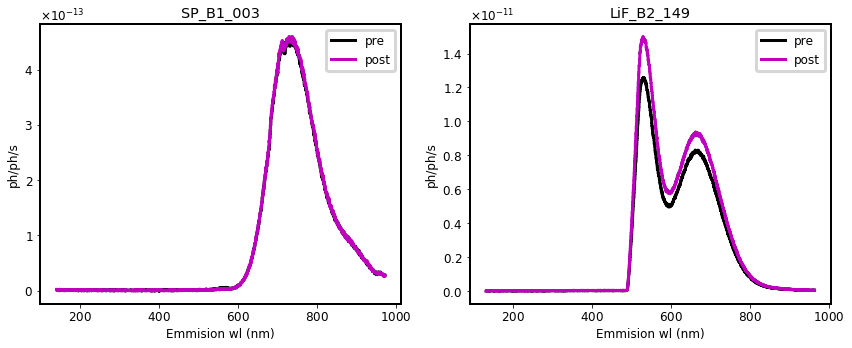

In [8]:
plot_references(experiment)

### Crystals

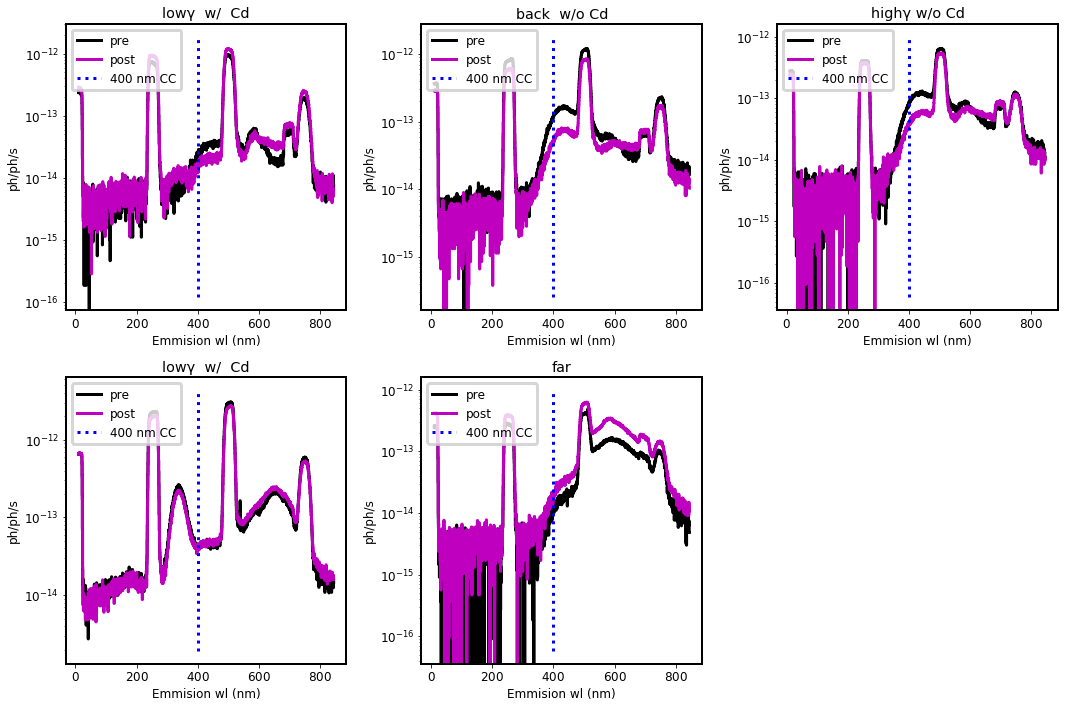

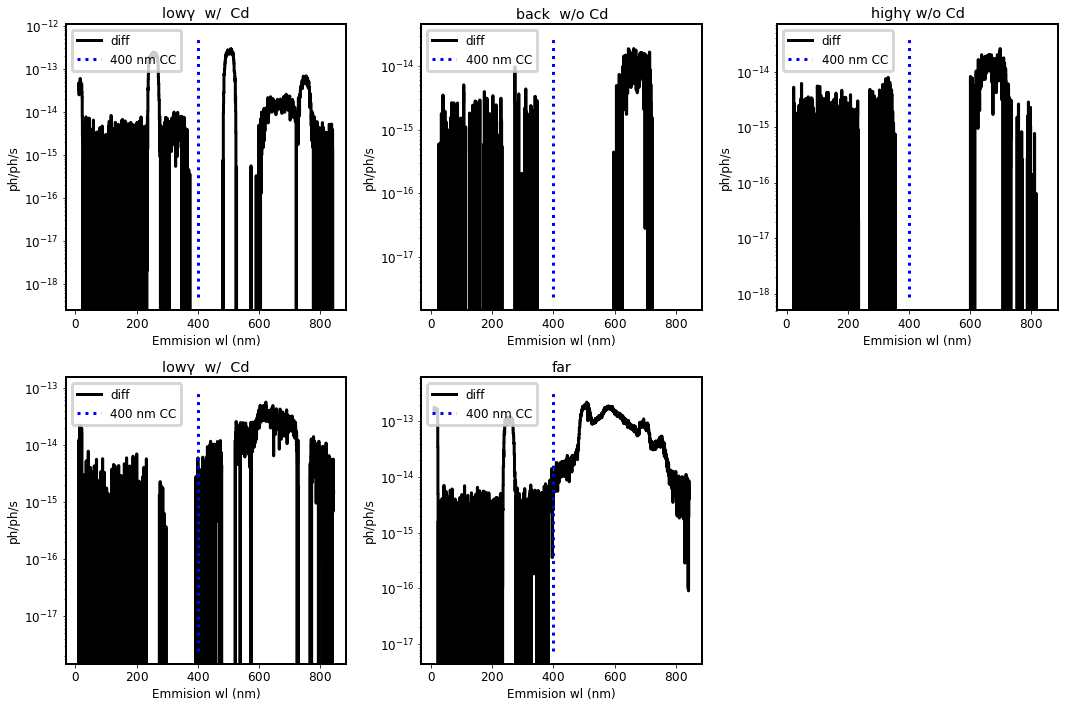

In [9]:
for plot_crystals in (plot_prepost, plot_diff):
    plot_crystals(experiment, expected_signals=signals, legend_position="upper left", ex_wl=250, exposure=10)

# Quartz

In [10]:
filename_pre  = "/Users/Gonzalo/github/CCdata/Seattle/Seattle_pre_Qz_1st_bunch.h5"
filename_post = "/Users/Gonzalo/github/CCdata/Seattle/Seattle_post_Qz_1st_bunch.h5"
signals       = 346,
experiment    = load_prepost(filename_pre, filename_post)

### References

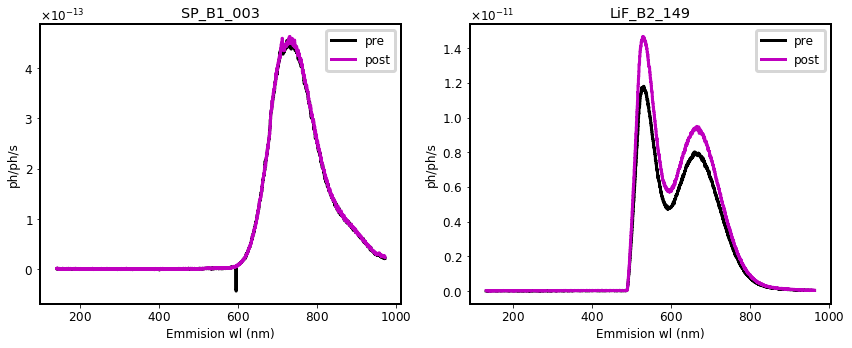

In [11]:
plot_references(experiment)

### Crystals

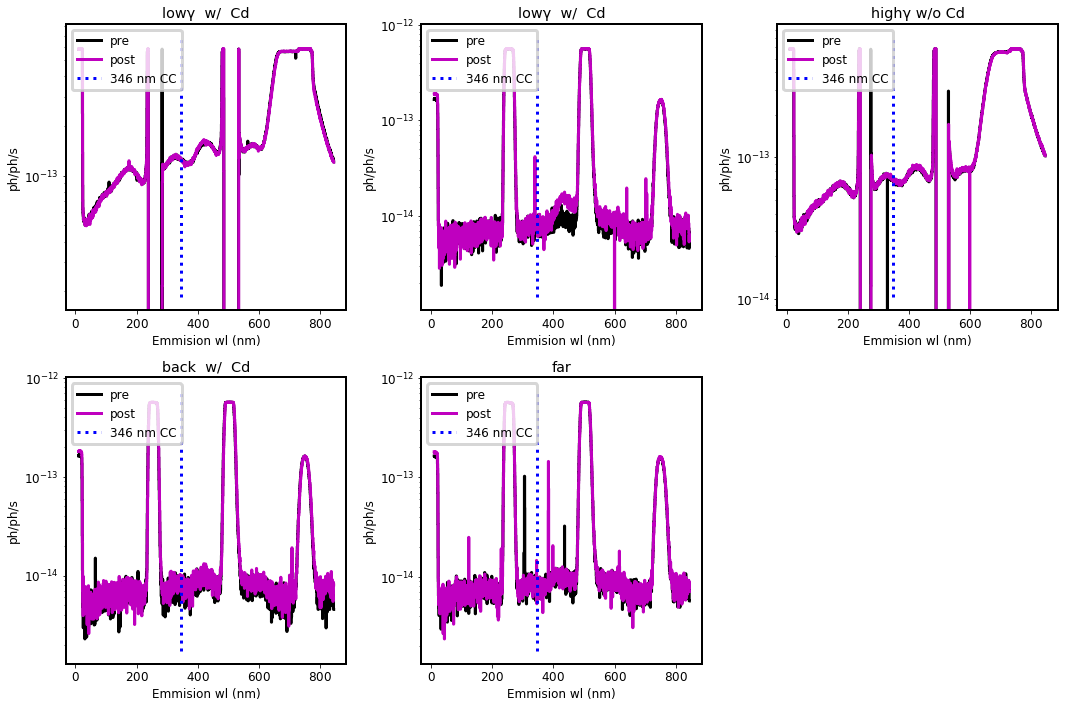

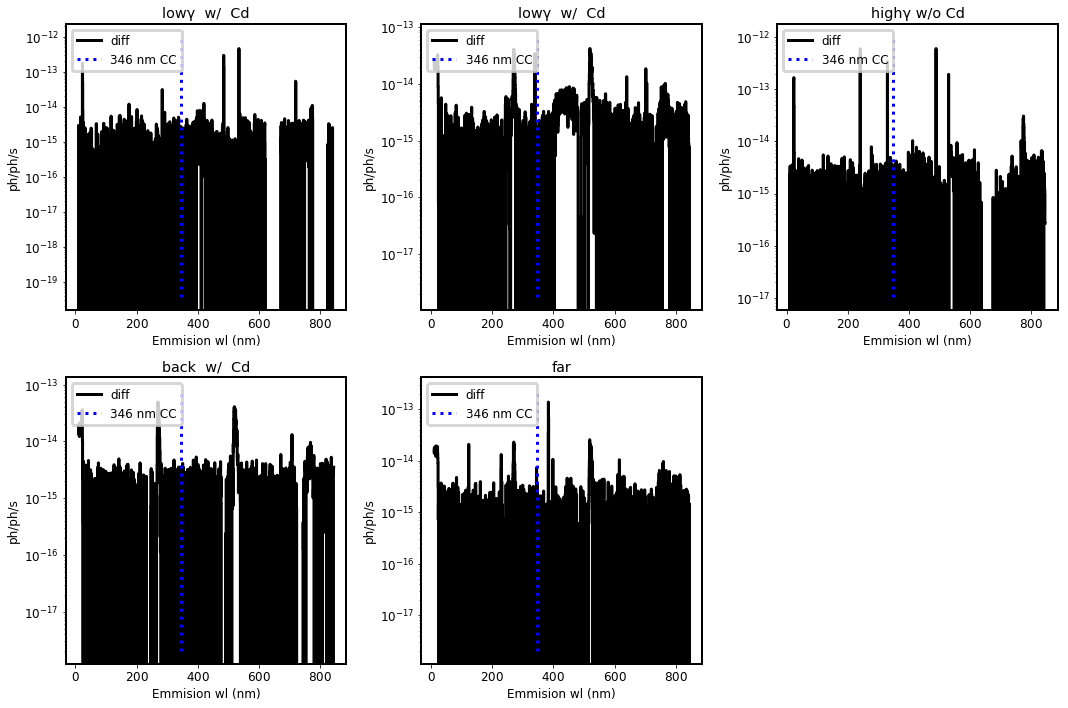

In [12]:
for plot_crystals in (plot_prepost, plot_diff):
    plot_crystals(experiment, expected_signals=signals, legend_position="upper left", ex_wl=250, exposure=100)

# BaF

In [13]:
filename_pre  = "/Users/Gonzalo/github/CCdata/Seattle/Seattle_pre_BaF_1st_bunch.h5"
filename_post = "/Users/Gonzalo/github/CCdata/Seattle/Seattle_post_BaF_1st_bunch.h5"
signals       = 570, 960
experiment    = load_prepost(filename_pre, filename_post)

### References

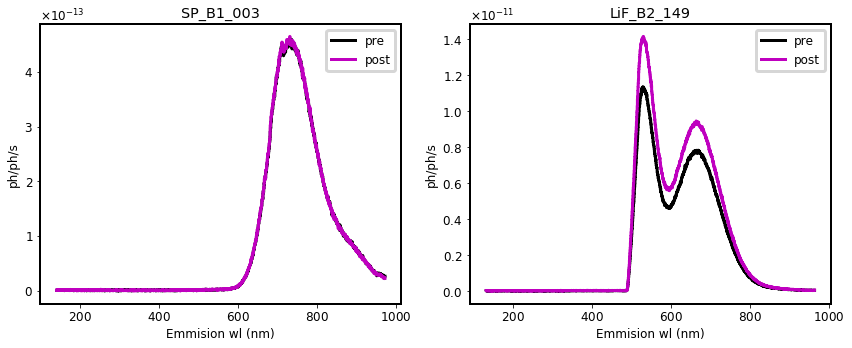

In [14]:
plot_references(experiment)

### Crystals

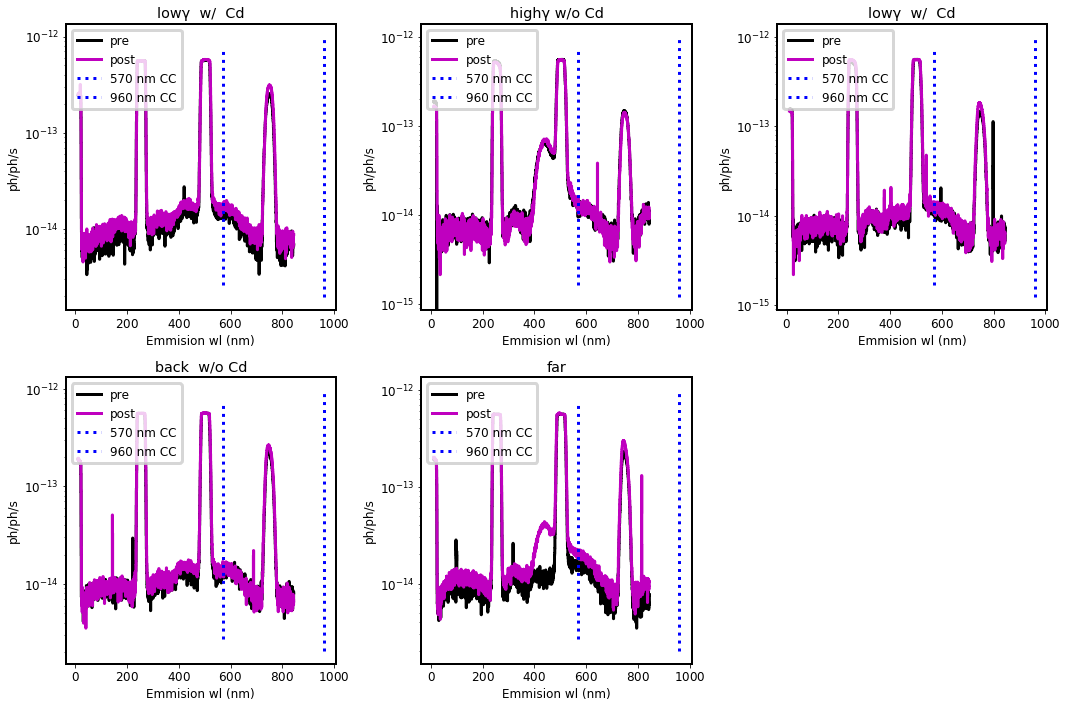

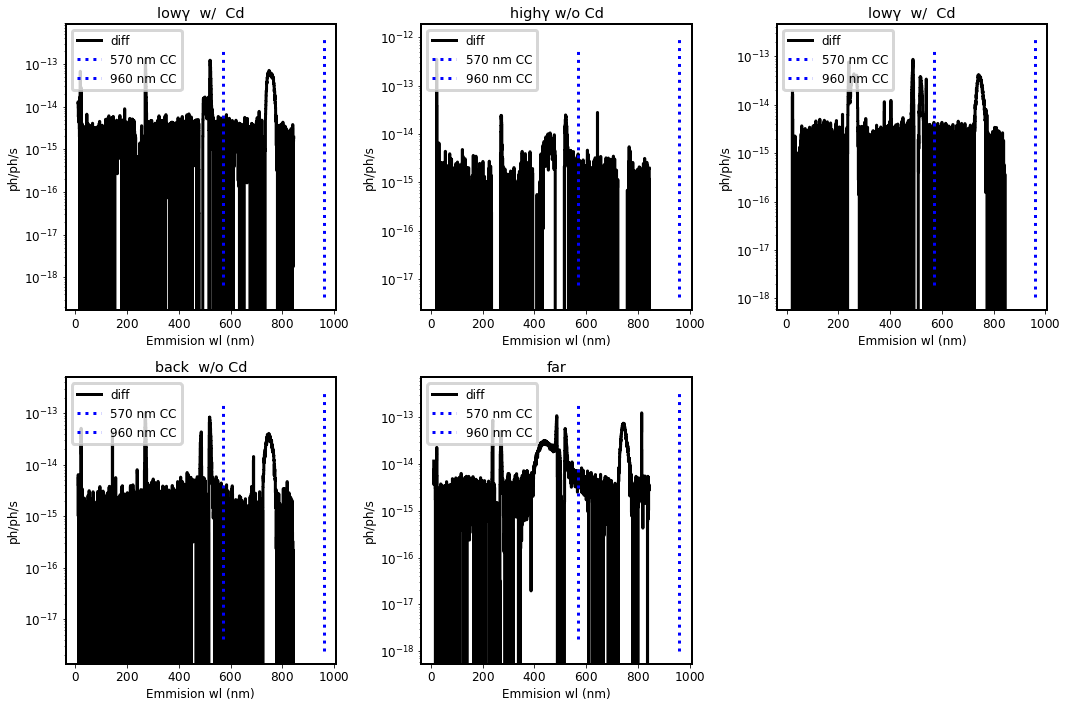

In [15]:
for plot_crystals in (plot_prepost, plot_diff):
    plot_crystals(experiment, expected_signals=signals, legend_position="upper left", ex_wl=250, exposure=100)

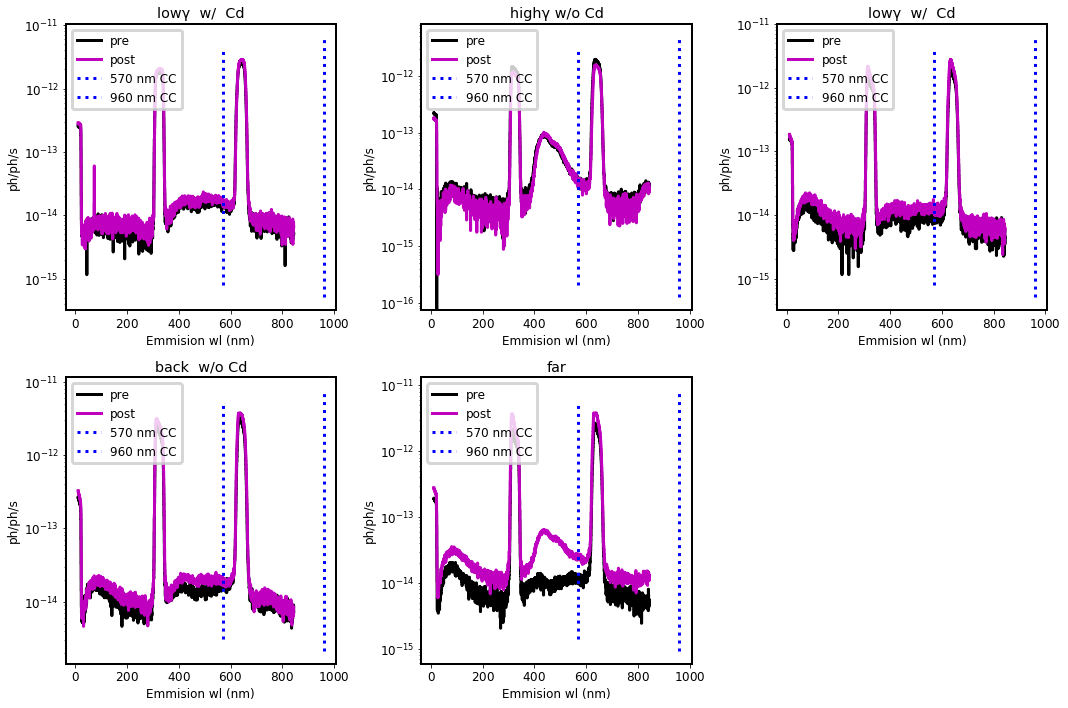

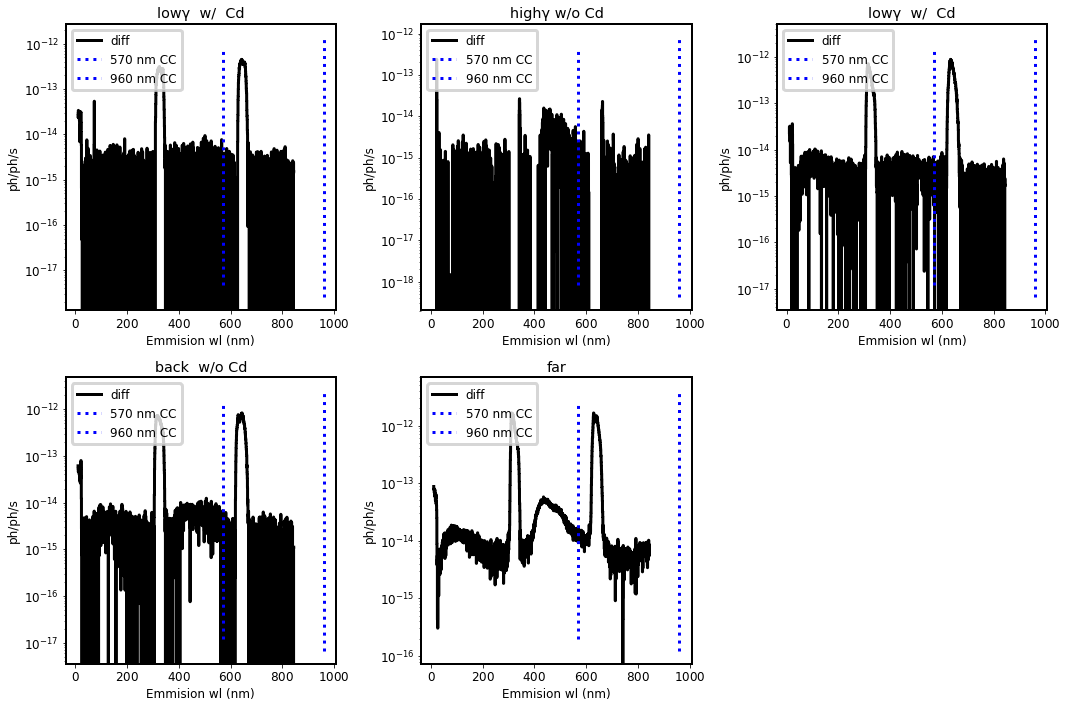

In [16]:
for plot_crystals in (plot_prepost, plot_diff):
    plot_crystals(experiment, expected_signals=signals, legend_position="upper left", ex_wl=320, exposure=10)

# CaF

In [17]:
filename_pre  = "/Users/Gonzalo/github/CCdata/Seattle/Seattle_pre_CaF_1st_bunch.h5"
filename_post = "/Users/Gonzalo/github/CCdata/Seattle/Seattle_post_CaF_1st_bunch.h5"
signals       = 580, 830, 770
experiment    = load_prepost(filename_pre, filename_post)

### References

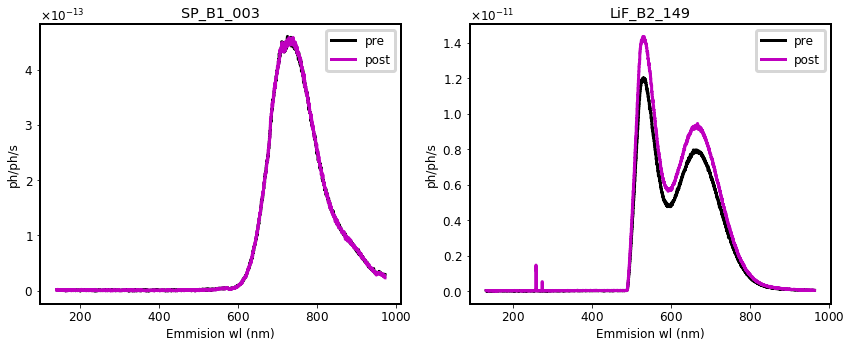

In [18]:
plot_references(experiment)

### Crystals

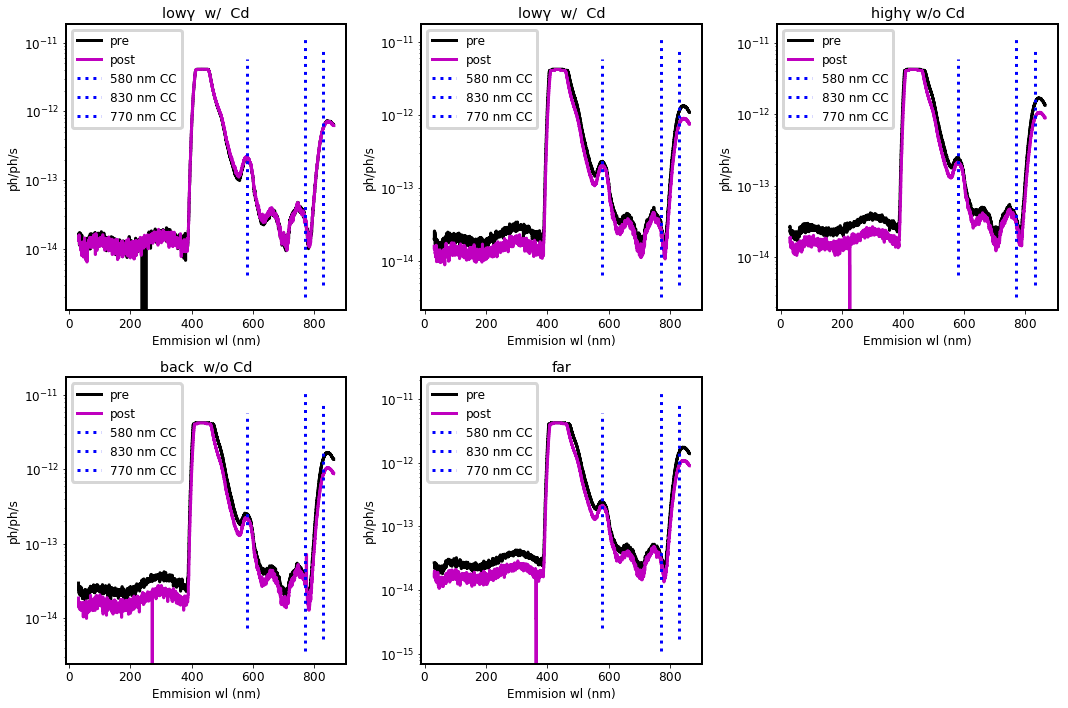

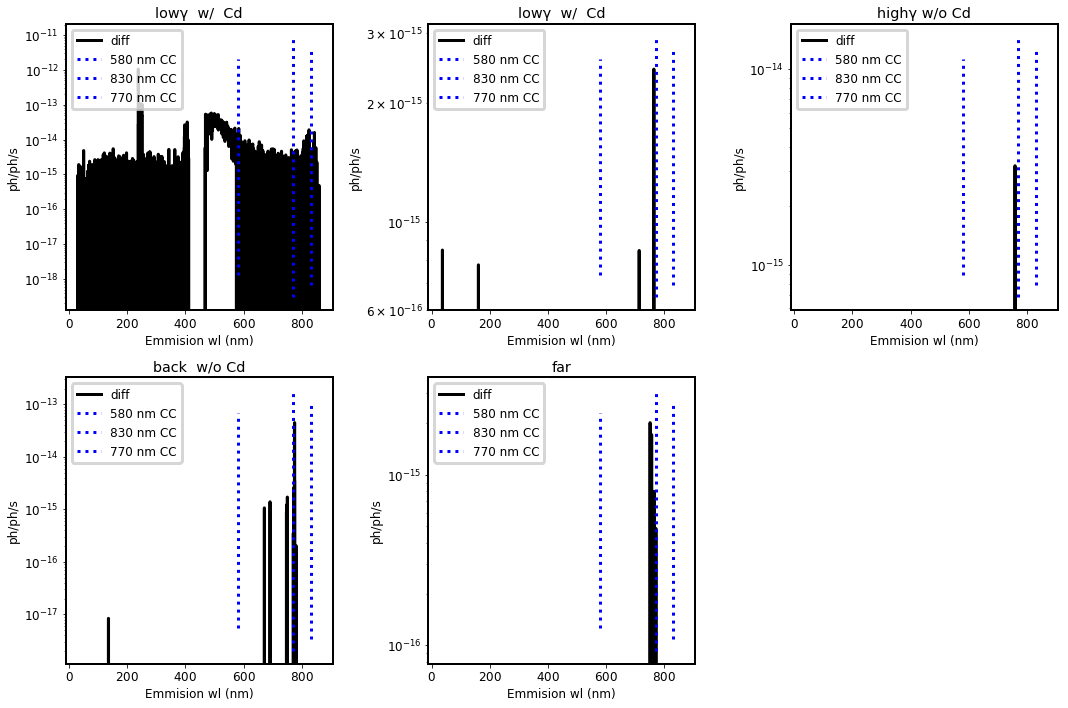

In [19]:
for plot_crystals in (plot_prepost, plot_diff):
    plot_crystals(experiment, expected_signals=signals, legend_position="upper left", ex_wl=350, exposure=10)

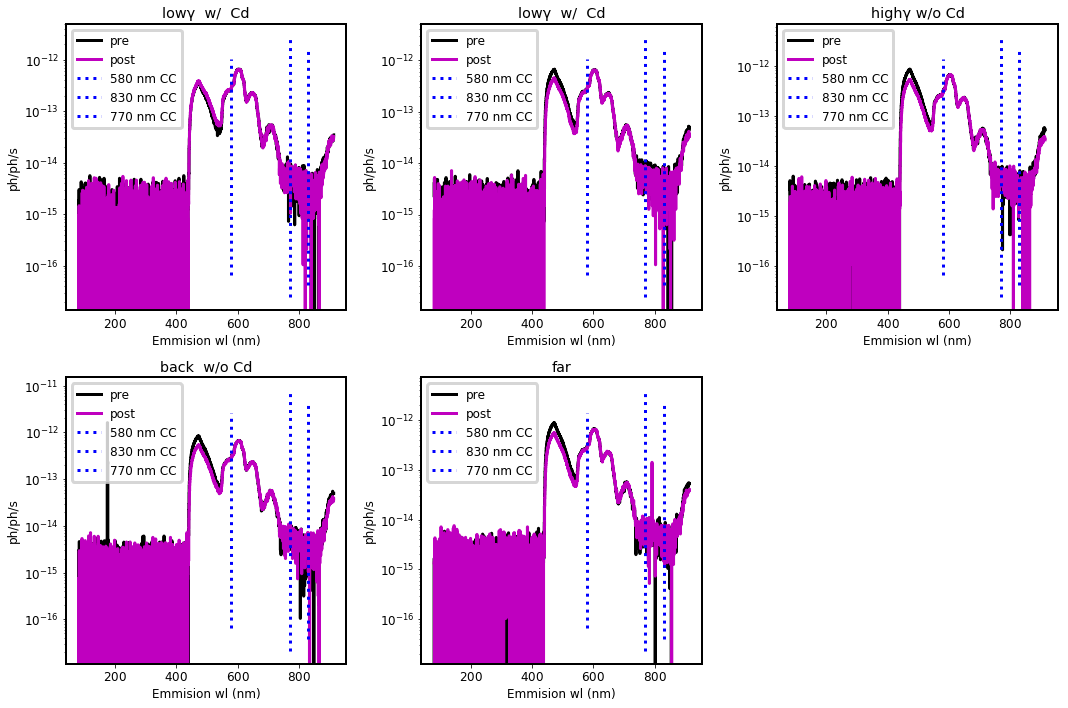

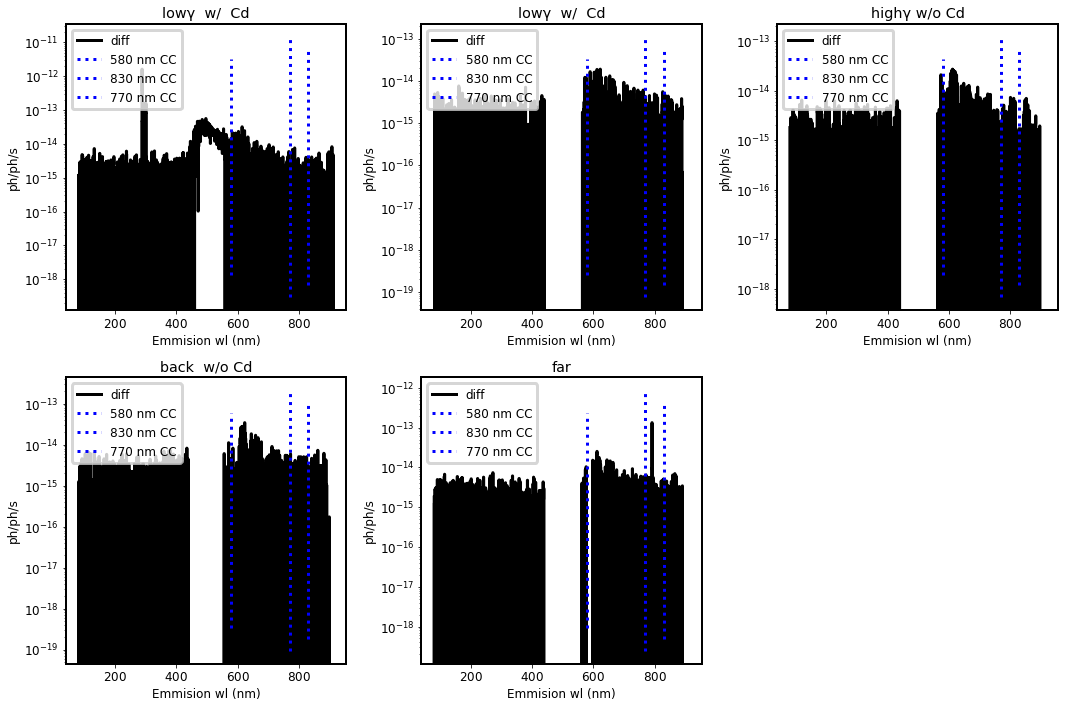

In [20]:
for plot_crystals in (plot_prepost, plot_diff):
    plot_crystals(experiment, expected_signals=signals, legend_position="upper left", ex_wl=400, exposure=10)

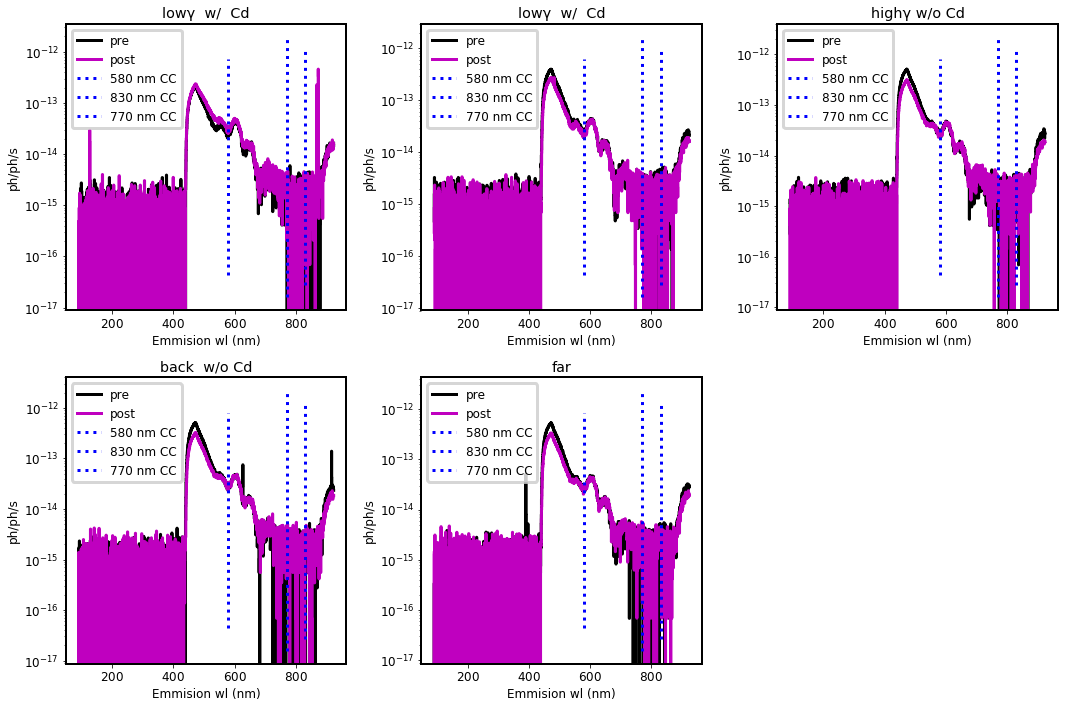

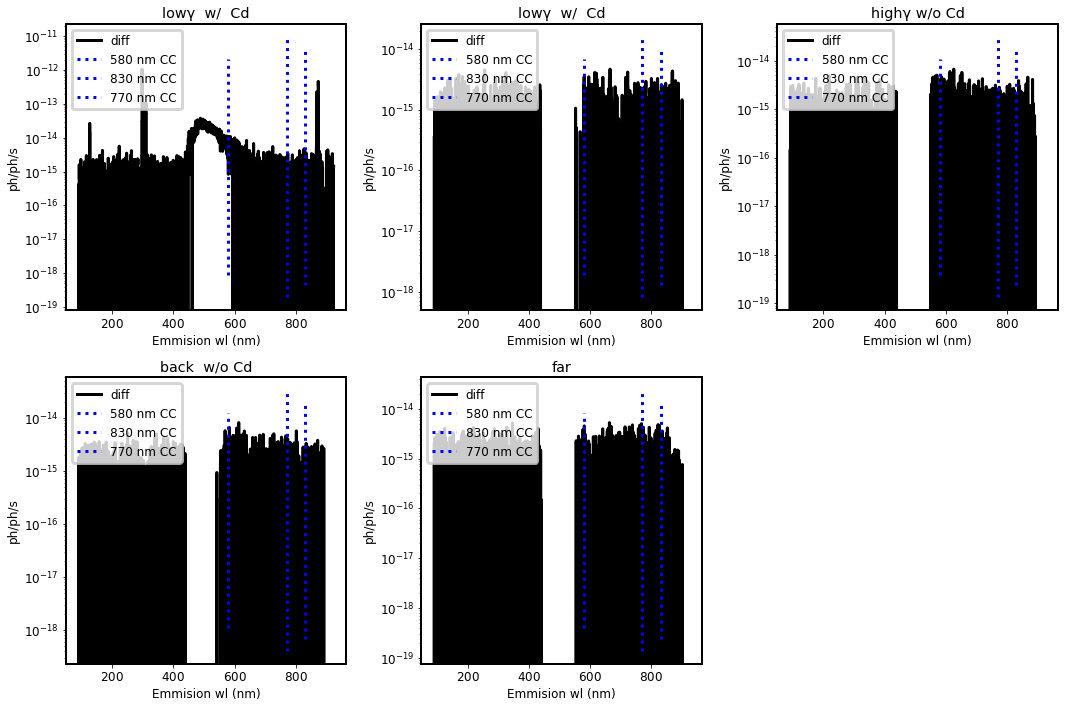

In [21]:
for plot_crystals in (plot_prepost, plot_diff):
    plot_crystals(experiment, expected_signals=signals, legend_position="upper left", ex_wl=410, exposure=10)

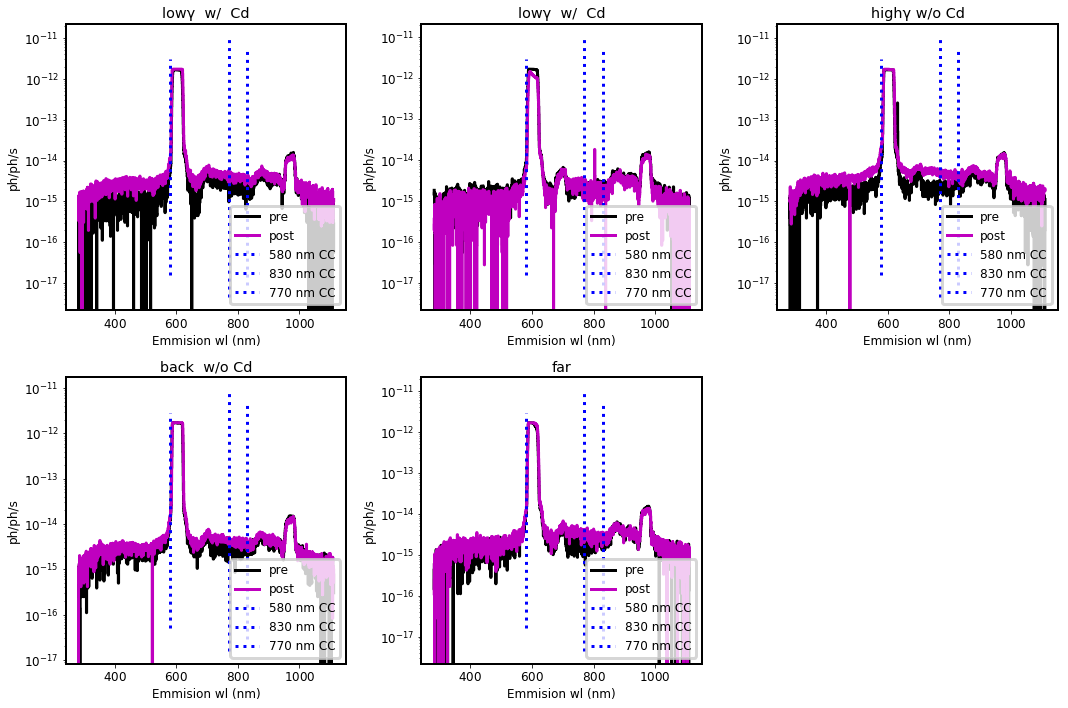

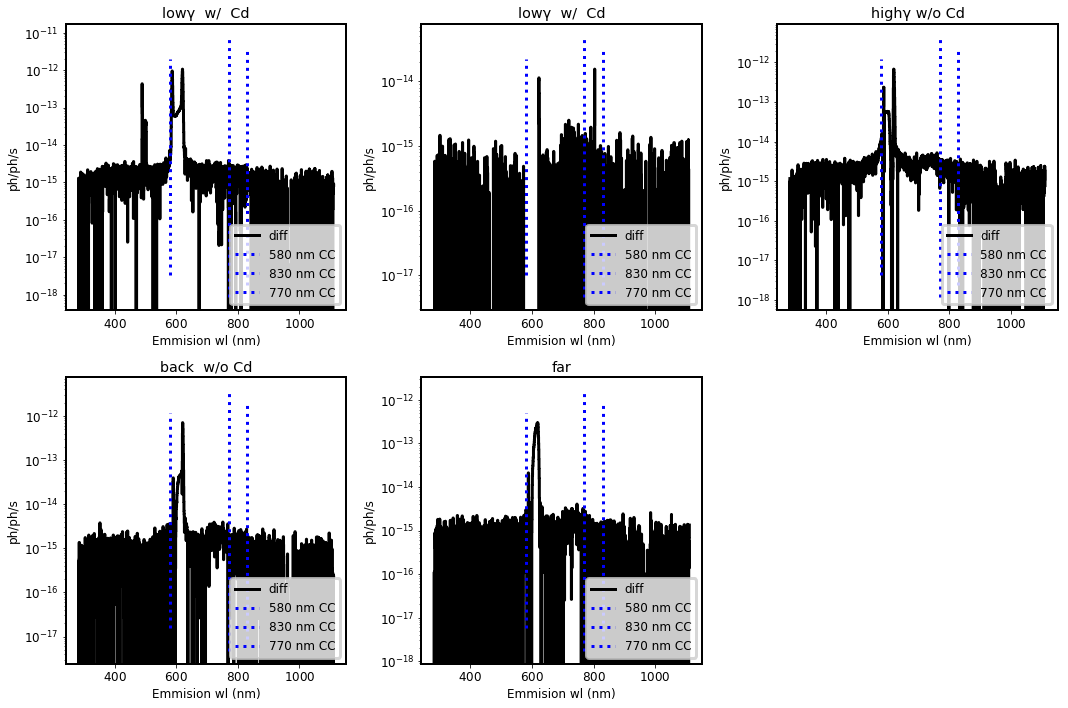

In [22]:
for plot_crystals in (plot_prepost, plot_diff):
    plot_crystals(experiment, expected_signals=signals, legend_position="lower right", ex_wl=600, exposure=10)